For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week4-wordnet-controlled-vocab/

# Week 4 Assignment: Working With a Controlled Vocabulary

In an earlier notebook we saw that the phrases "the world" and "the house" were particularly prevalent in Jane Austen's novels. How might we go about investigating how Austen imagined those realms?  One way might be to use a controlled vocabulary of words semantically linked to the landscape and the house to investigate how Austen talks about the surroundings of her characters.

In this notebook, we'll be working with a 'controlled vocabulary,' which is to say, expert-defined words that help to limit our pursuit of wordcount to words that share a certain semantic valence.  Controlled Vocabularies have been used in digital history to examine the history of words used by Victorian people to describe the way that strangers walked down the street, and to show that novelists in the nineteenth century described the urban landscape with increasing detail.  

First, we'll download some novels by Jane Austen to try our vocabulary on.  Then, we'll talk about how to clean the text using stemming and lemmatization.  

Next, we'll use a controlled vocabulary to limit the count to words that are interesting to us.  Then, we'll expand that controlled vocabulary using the 'hyponym' feature of the WordNet package, which consults with dictionaries of the English language organized by linguists at Princeton.  

Finally, we'll visualize our findings.


## Download some Jane Austen Novels

In [40]:
import nltk, numpy, re, matplotlib
import pandas as pd
import re
from textblob import TextBlob
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import matplotlib.pyplot as plt

In [41]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [42]:
with open('senseandsensibility.txt', 'r') as myfile:
    sas_data = myfile.read().split('\n\n"I suppose you know, ma\'am, that Mr. Ferrars is married"\n\nIt _was_ Edward\n\n"Everything in such respectable condition"\n\n ')[1].split('THE END')[0].strip()
with open('emma.txt', 'r') as myfile:
    emma_data = myfile.read().split('CHAPTER I')[1].split('FINIS')[0].strip()
with open('prideandprejudice.txt', 'r') as myfile:
    pap_data = myfile.read().split('CHAPTER I')[1].split('End of the Project Gutenberg EBook of Pride and Prejudice, by Jane Austen')[0].strip()
data = [sas_data, emma_data, pap_data]

In [58]:
# clean up
words = []

for novel in data:
    novel = re.sub('[\",.;:?([)\]_*]', '', novel) # strip punctuation
    novel = re.sub('-', ' ', novel) # replace hyphens with spaces
    novel = novel.lower() # lowercase
    novelwords = novel.replace('\n', ' ').split() # remove whitespace, split into words
    for word in novelwords:
        lemma = wn.morphy(word) # lemmatize them
        if lemma is not None:  # test that there was an answer
            words.append(lemma) # save the lemma for later

In [59]:
words[:10]

['chapter',
 'i',
 'family',
 'have',
 'long',
 'be',
 'settle',
 'in',
 'sussex',
 'estate']

#### A Little Critical Thinking
The only special thing we're doing to clean in this round is to replace hyphens with spaces.  If Austen writes 'dining-room,' we want to count it when we search later for "dining room." 

When working with a controlled vocabulary, we don't need to stopword, so we'll skip that step.

# Controlled Vocabulary

Let's look for what scholars call a "controlled vocabulary" -- a list of words that we know to be meaningful. For right now, let's pretend that we're researching the buildings, landscape, and furniture of nineteenth-century England.  I'm curious about what kinds of spaces are described in Austen, and I'd like to begin by counting them.

In [60]:
controlled_vocab = [
    "garden",
    "room", 
    "estate",
    "manor", 
    "hedge", 
    "residence",
    "park",
    "lane",
    "chair",
    "sofa",
    "settee",
    "bed",
    "bedroom",
    "chaise",
    "table",
    "rug",
    "carpet",
    "candelabra",
    "shed",
    "cottage",
    "fence",
    "turret",
    "castle",
    "palace",
    "hut",
    "dwelling"
]

In [61]:
controlled_words = []

for w in words:
    if w in controlled_vocab:
        controlled_words.append(w)

pd.Series.value_counts(controlled_words)

room         119
cottage       59
park          53
table         32
bed           27
estate        19
garden        16
chair         10
chaise         8
residence      7
dwelling       6
lane           6
shed           3
bedroom        3
carpet         2
rug            1
sofa           1
manor          1
dtype: int64

The process worked great! Now I know that Jane Austen was writing about a world of rooms, estates, cottages, and other dwellings, some of which have tables, gardens, beds, carpets, chaises, sofas, and chairs.

I accomplished my goal: working with a controlled vocabulary.

#### The Challenge is to Get Somewhere Interesting.

The only problem is... my results aren't very interesting.  What on earth can I say about this world of dwellings and furniture?? Not much.

It also occurs to me that I might not be thinking clearly about all the kinds of furniture, buildings, and other structures that might make up the Georgian landscape.  Fortunately, linguists have compiled many dictionaries that can help us to navigate the semantic universe with greater position.  Working with these dictionaries can enhance our controlled vocabulary search and lead us to more interesting results.

One of these dictionaries is **"Wordnet,"** the fruit of a long-term research undertaking at Princeton. We used one version of WordNet when we did the notebook on lemmatization, calling wn.morphy().  Now we'll use another part of Wordnet to call all the hyponyms for the word 'room,' and we'll see if we can get a more nuanced portrait of Austen's world.

# Expanded Controlled Vocabulary with Wordnet

In an earlier notebook, we saw that we could use the Wordnet package to generate a list of semantically-connected words.  We used the **.hyponyms()** function to narrow our word list.  Let's use the same code we saw previously to create a list of all the hyponyms for 'room.'

In [62]:
from nltk.corpus import wordnet as wn

mysynlist = wn.synset('room.n.01')

# get the hyponyms
hyposynlist = mysynlist.hyponyms()

# get the hyponyms of the hyponyms
finer_syns = [] # create an empty list
 
for syn in hyposynlist: # loop through all the synsets
    myhyponyms = syn.hyponyms()
    for h in myhyponyms:
        finer_syns.append(h)
  
# get the lemmas for everything so far
housinglemmas = [] # create an empty list
for syn in hyposynlist:
    for l in syn.lemmas():
        if l.name() not in housinglemmas: # check for uniqueness
            housinglemmas.append(l.name())

for syn in finer_syns:
    for l in syn.lemmas():
         if l.name() not in housinglemmas: # check for uniqueness
            housinglemmas.append(l.name())

# remove ambiguous words
housinglemmas2 = []

for word in housinglemmas:
    if word not in ['hall', 'court']:
        housinglemmas2.append(word)

housinglemmas2[:15]

# replace hyphens and underscores with spaces
cleanwordnetwords = []

for word in housinglemmas2:
    v = word.replace('-', ' ')
    v = v.replace('_', ' ') 
    cleanwordnetwords.append(str(v))
    
cleanwordnetwords[:30]

['anechoic chamber',
 'anteroom',
 'antechamber',
 'entrance hall',
 'foyer',
 'lobby',
 'vestibule',
 'back room',
 'ballroom',
 'dance hall',
 'dance palace',
 'barroom',
 'bar',
 'saloon',
 'ginmill',
 'taproom',
 'bathroom',
 'bath',
 'bedroom',
 'sleeping room',
 'sleeping accommodation',
 'chamber',
 'bedchamber',
 'belfry',
 'billiard room',
 'billiard saloon',
 'billiard parlor',
 'billiard parlour',
 'billiard hall',
 'boardroom']

Not all of these words will be useful for mining Jane Austen. If you look further down the list, you'll see that 'frat house' is one of the kinds of rooms listed.   

Austen is notorious for having few frat houses in her books. 

But Austen might have some billiard rooms or dance halls in her books, and that would be interesting to know about.  Let's use the Wordnet list instead of mine and repeat our search for a controlled vocabulary.

## Find the controlled wordnet vocabulary in Jane Austen

Next, let's run a "for" loop similar to those we've seen before to search for the words in *cleanwordnetwords* that also appear in Jane Austen novels.  As you'll recall, we have a master list of Austen words called "cleanaustenwords."

First, let's demonstrate how **not** to do it, using the operator "in."

In [63]:
matchedwords = []

for w in words:
    for v in cleanwordnetwords: 
        if w in v:
            matchedwords.append(v)

pd.Series.value_counts(matchedwords)[:30]

waiting area               10464
waiting room               10332
living room                 8546
dining room                 8480
withdrawing room            8448
operating theatre           8339
operating theater           8339
walk in                     8297
anechoic chamber            8149
sleeping accommodation      8014
exhibition hall             7844
council chamber             7803
operating room              7299
dining hall                 7244
exhibition area             7185
laminar flow clean room     7181
trading floor               6702
master bedroom              6655
diwan                       6545
drawing room                6500
reading room                6475
toilet facility             6365
hospital room               6347
cabinet                     6324
cabin                       6324
comfort station             6286
sitting room                6204
beer hall                   6161
torture chamber             6102
antechamber                 6075
dtype: int

Hmm, I'm not sure that's right.  There shouldn't be so many public lavatories or torture chambers in Jane Austen.  

What might have gone wrong?  The problem is 'in.'  By using this code:

        if w in v

-- we counted every word in Jane Austen that has one of the words in cleanwordnetwords inside it.  Thus the word "bed" appears 57 times in Jane Austen, and the phrase bed-and-breakfast appears in cleanwordnetwords.  The computer counted 57 bed-and-breakfasts in Jane Austen. That's just wrong!


***You can only catch errors of this kind if you're thinking (a) about the code and (b) about the history.***

*How can we tweak the code above to be more accurate?*

Here's another attempt using 'in' that works better:

In [76]:
matchedwords = []

for w in words:
    if w in cleanwordnetwords: 
         matchedwords.append(w)

pd.Series.value_counts(matchedwords)

well           241
can            217
john           148
keep            62
door            42
head            40
hold            22
parlour         11
study            7
convenience      5
chamber          4
snug             4
library          3
bedroom          3
floor            2
lobby            2
bath             2
kitchen          2
closet           2
lounge           1
toilet           1
parlor           1
vestibule        1
dtype: int64

Notice the difference between this code and the block of code above.  Instead of asking if each word w is "in" each vocab v, we ask if each word w is "in" the list controlled_vocab.

In text mining, to get good results, you must fit each piece of data just so.

Inspecting the results is a vital step to making sure you're getting good results.

#### Inspecting the results for ambiguous words

Even though the match between the two lists is now accurate, the results still require further cleaning to be useful for the purpose of analysis.

Some of these words are false positives.  The words "can," "well," "john," "head," "keep," and so forth have too many meanings to tell us about Jane Austen.  I'm also wary of 'toilet,' which in nineteenth-century English probably refers to the practice of grooming rather than to a room in the house.

Let's stopword our list based on our own understanding of which words are meaningful, i.e., unambiguously about our research subject, Jane Austen's world.

In [91]:
ambiguouswords = ['can', 'head', 'well', 'toilet', 'john', 'keep', 'hold', 'study', 'convenience', 'snug', 'floor']

matchedwords = []

for w in words:
    for v in cleanwordnetwords: 
        if w == v: 
            if v not in ambiguouswords:
                matchedwords.append(v)
matchedwords
pd.Series.value_counts(matchedwords)

door         42
parlour      11
chamber       4
library       3
bedroom       3
kitchen       2
bath          2
closet        2
lobby         2
parlor        1
lounge        1
vestibule     1
dtype: int64

That's much better. We can begin to interpret it.

 * In Jane Austen's world, the 'doors' separating inside from outside have particular meaning. We might speculate that doors suggest privacy, but we'd need in-text mentions to understand why she invokes them so often.
 * The 'parlour' is also important as a meeting place where the family received company.  We'd also want to read a few mentions and perhaps some plot summaries of her novels to understand who is being received in parlours and why there are so many of them.
 * Jane writes about a world where people have dedicated libraries.
 * More humble spaces like the kitchen are mentioned with extreme infrequency. We can ascertain that the drama of the novel happens in more public spaces like the "parlour" or at the "door" where private and public meet.



## Bigrams


We still aren't getting all the information.

The variable *cleanaustenwords* contains strings that are one-word long. 

We're matching it with *cleanwordnetwords* -- which includes such two-word phrases such as "terraced house." 

Those two-word phrases aren't getting accurately matched. 

We need bigrams.






Remember that in an earlier exercise we learned how to find all the bigrams in Jane Austen.



In [84]:
from textblob import TextBlob

austenbigramlist = [] # create an empty list which we will fill in with the following loop:


for novel in data:
    novel = re.sub('[\",.;:?([)\]_*]', '', novel) # strip punctuation
    novel = re.sub('-', ' ', novel) # replace hyphens with spaces
    novel = novel.lower() # lowercase
    bigrams = TextBlob(novel).ngrams(n=2)
    for bigram in bigrams: # move through each line of the *bigrams* list
        bigram2 = bigram[0] + ' ' + bigram[1] # call the first word, a space, and the second word into a new string
        austenbigramlist.append(bigram2) # save the string 

austenbigramlist[:15]

['chapter i',
 'i the',
 'the family',
 'family of',
 'of dashwood',
 'dashwood had',
 'had long',
 'long been',
 'been settled',
 'settled in',
 'in sussex',
 'sussex their',
 'their estate',
 'estate was',
 'was large']

Let's write a loop to find just the multiword phrases in our wordnet words.  We'll search for the presence of a space (' ').  Then we'll save those words with spaces as the new variable, *cleanwordnetbigrams*.

Just to be sure we're getting everything, we can also add back a version of word that has the space removed, so that our search will look for "bedroom" as well as "bed room." 

In [85]:
cleanwordnetbigrams = []
for vocab in cleanwordnetwords:
    if " " in vocab:
        cleanwordnetbigrams.append(vocab)
        cleanwordnetbigrams.append(vocab.replace(' ', ''))

cleanwordnetbigrams[:10]

['anechoic chamber',
 'anechoicchamber',
 'entrance hall',
 'entrancehall',
 'back room',
 'backroom',
 'dance hall',
 'dancehall',
 'dance palace',
 'dancepalace']

Here's the loop to match the bigrams in austen -- from *austenbigramlist* -- with the multi-word phrases in cleanwordnetwords -- from _cleanwordnetbigrams_.

In [87]:
matchedbigrams = []

for w in austenbigramlist:
    if w in cleanwordnetbigrams: 
        matchedbigrams.append(w)

pd.Series.value_counts(matchedbigrams)

drawing room     20
sitting room      4
dining room       4
dressing room     2
walk in           1
billiard room     1
dtype: int64

We have successfully searched for bigrams with a controlled vocabulary, and added the phrase "drawing room" to our list of spaces important to the world of  Jane Austen.

Again we can begin an interpretation from these findings.

  * Mainly, Austen invokes public spaces of great estates where the sexes would mingle -- the "drawing room," "dining room," and "sitting room" are places where both women and men would convene.  
  * We might also suspect, if we know much about country houses, that Austen is making references to spaces occupied only by men, for instance the "billiard room"  
  * Notably, we still see far less of the places reserved for women -- like bed rooms -- or for servants, like cottages or kitchens.  

***Please note that it is the analyst's responsibility to deal appropriately with noise:***

   * I will ignore "walk in" -- which in some twentieth-century apartment buildings is a kind of suite.  Austen was probably using the word "walk" as a verb. If I were making a data visualization, I would eliminate "walk in" from my data before graphing it so that the reader isn't confused.  

#### Putting it all together

All that remains is for us to put everything together using the operator **+**.

In [88]:
allcontrolledvocab = matchedwords + matchedbigrams  
pd.Series.value_counts(allcontrolledvocab)

door             42
drawing room     20
parlour          11
chamber           4
sitting room      4
dining room       4
bedroom           3
library           3
dressing room     2
lobby             2
kitchen           2
bath              2
closet            2
vestibule         1
walk in           1
lounge            1
billiard room     1
parlor            1
dtype: int64

Our controlled vocabulary search has successfully illuminated the world of Jane Austen.

## Summing up

Here is the complete code for this notebook.

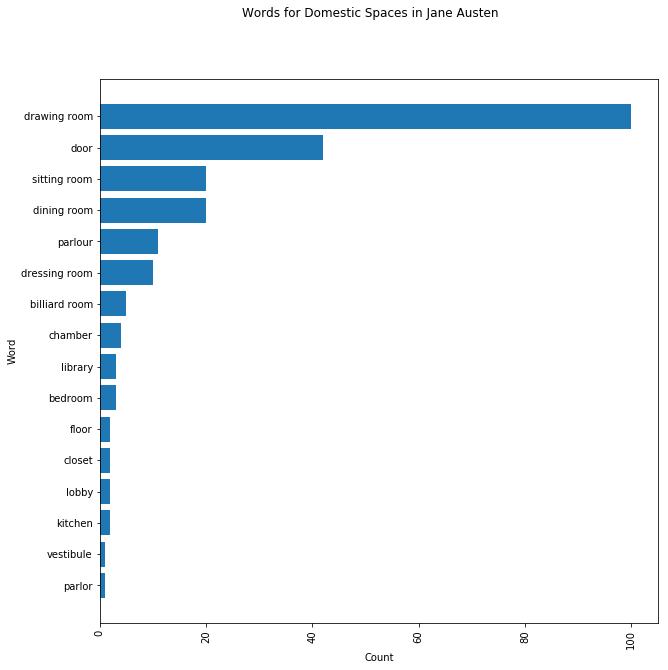

In [99]:
# assume 'words' -- the list of words where you'll search
# assume 'cleanwordnetwords' -- a list of controlled vocabulary where you'll search

# search for matched words
matchedwords = []
for w in words:
    if w in cleanwordnetwords: 
        matchedwords.append(w)
matchedwords
pd.Series.value_counts(matchedwords)

# search for matched bigramsaustenbigramlist = [] # create an empty list which we will fill in with the following loop:
for novel in data:
    novel = re.sub('[\",.;:?([)\]_*]', '', novel) # strip punctuation
    novel = re.sub('-', ' ', novel) # replace hyphens with spaces
    novel = novel.lower() # lowercase
    bigrams = TextBlob(novel).ngrams(n=2)
    for bigram in bigrams: # move through each line of the *bigrams* list
        bigram2 = bigram[0] + ' ' + bigram[1] # call the first word, a space, and the second word into a new string
        austenbigramlist.append(bigram2) # save the string 
matchedbigrams = []
for w in austenbigramlist:
    if w in cleanwordnetbigrams: 
        matchedbigrams.append(w)
pd.Series.value_counts(matchedbigrams)

# put it all together and stopword out ambiguous words
ambiguouswords = ['can', 'john', 'toilet', 'bath', 'well', 'keep', 'head', 'hold', 'convenience', 'snug', 'study', 'walk in', 'lounge']
finallist = []
allcontrolledvocab = matchedwords + matchedbigrams  
for v in allcontrolledvocab:
    if v not in ambiguouswords:
        finallist.append(v)
finalcount = pd.Series.value_counts(finallist)

#######
# a well-labeled barplot
plt.figure(figsize = (10, 10)) # make it medium and square
plt.barh(finalcount.index, finalcount) # tell the barplot what to put on the x and y axes. This time we're using 'barh' for a horizontal bar plot.
plt.xticks(rotation=90) # this tells Python to 'rotate' the labels on the x axis so that the words fit on the screen
plt.savefig('bar.png') # this line tells Python to save a copy in your digital-history folder
plt.ylabel('Word') # label
plt.xlabel('Count') # label
plt.suptitle('Words for Domestic Spaces in Jane Austen') #This line labels the title
plt.gca().invert_yaxis() # reverse the order of the y axis
plt.savefig('austen-spaces.png', dpi = 300) # save the figure in your folder
plt.show() # display the figure below

# Assignment 

*To be turned in on Canvas*

### 1) In this exercise, you will use Wordnet to compile a list of terms that can help us to explore Jane Austen's word.  

Brainstorm a list of possible places where Austen's characters might go. The fireside? The dance hall? A carriage? Town? Do they see rivers? cottages? thatched huts? Do they look out of windows? Or is their world mostly one of dresses, wigs, gowns, and other ornaments? Perhaps they go to church? Perhaps family relationships are more important than places, and cousins, uncles, and daughters are really what's important?

Use your thoughts as the basis for expanding your controlled vocabulary.  In this exercise, we only took the hyponyms from one synset -- room.n.01.  But you could take the hyponyms from another synset.  Alternatively, you could look for synsets that contain the word 'furniture' or 'garden.' You can use the formula Word('garden').synsets to call up the synsets for those words, and you can plug those synsets into our code to find multiple-word formulae.

Once you have a synset that you think is meaningful, run it through the code that follows to produce a new list of matches in Jane Austen.  

What you choose is up to you. Play with Wordnet and the code until you are able to expand from a few queries to a list of words that actually returns meaningful results when matched against the text.

This assignment requires a process of exploration and trial and error.

### 2) Make a data visualization of your findings.

Use the bar plot format to graph the most popular places in Jane Austen according to your research.

You will want to combine the matched bigrams and matched individual words into one dataset before graphing.

You will want to make sure to eliminate ambiguous words and redundancies from your results.

As always, make sure it is well-labled and consistent.

Embed the data visualization into a Word Document.

In [97]:
from textblob import Word

for synset in Word('park').synsets:
    for lemma in synset.lemmas():
        print(lemma.name())

park
parkland
park
commons
common
green
ballpark
park
Park
Mungo_Park
parking_lot
car_park
park
parking_area
park
park
park


In [98]:
for synset in Word('park').synsets:
    for s in synset.hyponyms():
        for lemma in s.lemmas():
            print(lemma.name())

national_park
safari_park
amusement_park
funfair
pleasure_ground
village_green
used-car_lot
angle-park
double-park
parallel-park


### 2) Write an interpretive paragraph of at least five sentences making some observations about the built landscape of England at the time of Jane Austen. 

Where appropriate, refer to the data visualization you have made as a source of evidence. Talk about as many words in the visualization as you can.

Where appropriate, use the text of Jane Austen's novels to elucidate the meaning of words whose implications are unclear to you.  Look up in-text mentions of the places you found. 

  * Sense and Sensibility: https://www.gutenberg.org/files/161/161-h/161-h.htm
  * Pride and Prejudice: https://www.gutenberg.org/ebooks/1342
  * Emma: https://www.gutenberg.org/files/158/158-h/158-h.htm 
  
Make a well-supported arguments.

Offset phrases and words found in the text with quotation marks. Use footnotes to tell us where each direct quotation is from.


### Help where help is needed

If you're finding yourself confused about the code and how to follow directions at this point, bear in mind that we're moving very quickly through the introduction to Python. You might need to slow down and revisit some of the "optional" notebooks that we mentioned in Weeks 1-2.  Here they are again:

- lists : https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/lists.ipynb
- for loops : https://problemsolvingwithpython.com/09-Loops/09.01-For-Loops/
- expressions and strings :  https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/expressions-and-strings.ipynb
- dictionaries, sets, tuples: https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/dictionaries-sets-tuples.ipynb
- counting things: https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/counting.ipynb

Remember that SMU expects you to be spending around 6 hours every week on your homework for this class.  Don't be afraid to keep tweaking the code until it works -- or reaching out on Slack if you need encouragement from others.  

Also, please bear in mind that everyone who learns how to code ultimately does so through a lot of trial and error.  Try typing in code and running it. When you run into trouble, you can google your problems and find stack overflow results or blog entries that match your problem and suggest solutions.  The more you try, the faster you will master code.  

Don't give up!  Keep trying things until you feel like you're getting it! 

